In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.io

contents = scipy.io.loadmat('project_data.mat',squeeze_me=True)
freq = np.asarray(contents['nu']) #reading freq.column in an array
Signal = np.asarray(contents['signal']) #reading Signal column
SpN = np.asarray(contents['signal_plus_noise']) # Signal + Noise

# Newton-Raphson Optimization functions

def NR_Single(vi,xi,theta,sgm,r=0.4):
    
  A = theta[0][0]; nu = theta[1][0]; a = theta[2][0]

  # intermediate calculation result
  m_1 = vi/nu; m_2 = m_1+1
  m_3 = A*(m_1)**a - xi*(m_2)**(4*a)
  m_4 = (nu-3*vi)/(nu+vi)/nu
  m_5 = np.log(m_1) - 4*np.log(m_2)
  m_6 = m_1**(a) * m_2**(-8*a)
  m_7 = m_3 + A*(m_1)**a
  mnu_1 = xi*(m_2)**(4*a) * ((9*a-3)*m_1**2 + (a+1)*(1-6*m_1))
  mnu_2 = A*(m_1)**a * ((18*a-3)*m_1**2 + (2*a+1)*(1-6*m_1))

  # First derivatives
  dA = - m_3 * m_1**a * m_2**(-8*a)
  dnu = - m_4 * dA * A * a
  da = m_5 * dA * A
  
  # Put first derivatives in matrix
  F = np.array([[np.sum(dA)],[np.sum(dnu)],[np.sum(da)]])
  F = F/sgm**2

  # Second derivatives
  dA2 = - m_1**(2*a) * m_2**(-8*a)
  dAdnu = m_4 * m_6 * m_7 * a
  dAda = - m_6 * m_5 * m_7
  dnu2 = a*A*(nu+vi)**(-2) * m_6 * (mnu_1 - mnu_2)
  dnuda = m_4 * m_6 * (a*m_5*m_7 + m_3) * A
  da2 = - m_6 * m_5**2 * m_7 * A

  # Put second partial derivatives in matrix
  J = np.zeros((3,3))
  J[0,0] = np.sum(dA2); J[2,2] = np.sum(da2)
  J[0,1] = J[1,0] = np.sum(dAdnu) # dA dv
  J[0,2] = J[2,0] = np.sum(dAda) # dA dalpha
  J[1,1] = np.sum(dnu2) # dv2
  J[1,2] = J[2,1] = np.sum(dnuda) # dv dalpha
  J = J/sgm**2

  dtheta = np.linalg.solve(J,F)*r
  theta_new = theta - dtheta
  
  return theta_new,F,J

def NR_optimization(freq,data,sgm2,N=20,r=0.4,A=6,nu_0=2,alpha=1):
  F_array = np.zeros((3,1)); err_data = np.array([])
  theta_array = np.array([[A],[nu_0],[alpha]])

  s = lambda x: Af * (x/nuf) ** alf * (1 + x/nuf)**(-4*alf)

  for i in range(N):
    theta = np.reshape(theta_array[:,-1].copy(),(3,1))
    theta_new,F_new,dump = NR_Single(freq,data,theta,sgm2,r)
    theta_array = np.hstack((theta_array,theta_new))
    F_array = np.hstack((F_array,F_new))

    Af = theta_array[0][-1]; nuf = theta_array[1][-1]; alf = theta_array[2][-1]
    Cal = s(freq)
    erdata = np.sum((SpN - Cal)**2)
    err_data = np.append(err_data,erdata)
  
  return theta_array,F_array,err_data

# Q4 function for calculating CRLB

def CRLB(vi,A,nu,a,sgm):

  s = lambda x: A * (vi/nu)**a * (1+vi/nu)**(-4*a)
  xi = s(vi); theta = np.array([[A],[nu],[a]])
  Fisher = NR_Single(vi,xi,theta,sgm)[2]
  CRLB = -np.linalg.inv(Fisher)

  return CRLB

# Q5 function for generating 3D PDF

def PDF_3D(vi,xi,mu3,R3,N=150):

  sgm=0.05; C = - 0.5/sgm/sgm
  axes = []; unit = np.array([]); pdf_3dmtx = np.zeros((N,N,N))
  PDFs_1D = np.zeros((3,N)); PDFs_2D = np.zeros((3,N,N))
  s = lambda x: A * (x/nu)**a * (1+x/nu)**(-4*a)

  # Create the coordinates of the 3D PDF
  for i in range(3):
    axes.append(np.linspace(mu3[i]-R3[i],mu3[i]+R3[i],N))
    unit = np.append(unit,axes[i][1]-axes[i][0])
  # Calculate the probability of each grid point
  for i in range(N):
    for j in range(N):
      for k in range(N):
        A = axes[0][i]; nu = axes[1][j]; a = axes[2][k]
        pdf_3dmtx[i,j,k] = np.exp(np.sum((xi - s(vi))**2) * C)
  # Normalize the PDF to 1
  norm_C = np.sum(pdf_3dmtx)*np.prod(unit)
  pdf_3dmtx = pdf_3dmtx/norm_C

  # integrate 3D PDF to 1D
  for i in range(N):
    PDFs_1D[0,i] = np.sum(pdf_3dmtx[i,:,:])*np.prod(unit)/unit[0]
    PDFs_1D[1,i] = np.sum(pdf_3dmtx[:,i,:])*np.prod(unit)/unit[1]
    PDFs_1D[2,i] = np.sum(pdf_3dmtx[:,:,i])*np.prod(unit)/unit[2]
  # integrate 3D PDF to 2D
  for j in range(N):
    for k in range(N):
      PDFs_2D[0,N-j-1,k] = np.sum(pdf_3dmtx[:,j,k])*unit[0]
      PDFs_2D[1,N-j-1,k] = np.sum(pdf_3dmtx[j,:,k])*unit[1]
      PDFs_2D[2,N-j-1,k] = np.sum(pdf_3dmtx[j,k,:])*unit[2]

  return PDFs_1D, PDFs_2D, axes

# Q6 MCMC sample Function (Copy)

def MCMC_fit(vi,xi,Vars,N=10**5):

  def m_dot(p,vi=vi,xi=xi):
    sgm = 0.05; C = 0.5/sgm/sgm
    mi = p[0]*(vi/p[1])**p[2]*(1+vi/p[1])**(-4*p[2])
    dif = xi - mi
    return dif.T @ dif * C

  ss = Vars**0.5*3; m_array = np.array([])
  para_trace = np.array([[6],[2],[1]]); i = 0; swt=0
  
  while i < N:
    vp_new = para_trace[:,-1] + np.array([np.random.normal(0,ss[k]*(1-2*swt/3)) for k in range(3)])
    m_old = m_dot(para_trace[:,-1]); m_new = m_dot(vp_new)

    if np.log(np.random.rand()) <= m_old-m_new: 
      para_trace = np.hstack([para_trace,np.reshape(vp_new,(3,1))])
      m_array = np.append(m_array,m_new)
      i += 1
      if i == 100 : swt = 1
      
  return para_trace, m_array

# **Statistical Signal Processing Project**


<div class="alert alert-block alert-success"> <font color='green'>

N.B. If the results need to be reproduced, please run the first cell to import all the packages and necessary functions.
    
</div>

Text(0.5, 0, 'Freq')

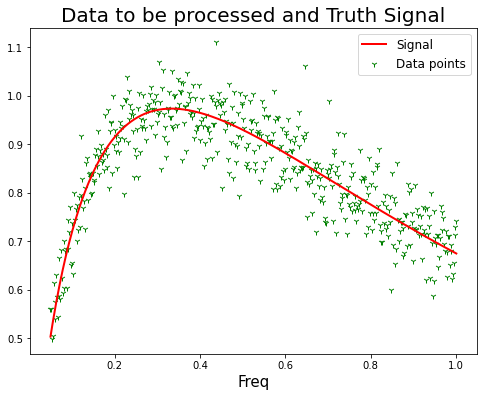

In [2]:
fig = plt.figure(figsize=(8,6))
plt.title('Data to be processed and Truth Signal',fontsize=20)
plt.plot(freq,Signal,c='r',lw=2,label='Signal')
plt.scatter(freq,SpN,c='g',marker='1',lw=1,label='Data points')
plt.legend(fontsize=12); plt.xlabel('Freq',fontsize=15)

In this project, we have the obeserved data is in the form of $\vec x = \vec s + \vec w$, where $\vec w$ is white Gaussian noises, $w_i \sim {\cal N}(0, 0.0025)$.

We will fit the above data with given signal model

$$ s = A \left( \frac{\nu}{\nu_0} \right)^{\alpha} \left( 1 + \frac{\nu}{\nu_0} \right)^{- 4 \alpha}  $$

and each data point can be written as 

$$ x_i = A \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 4 \alpha} + w_i $$

where $\nu$ is the frequency (independent variable), and we need to find out the parameters $A$, $\nu_0$ and $\alpha$ as the estimates by two methods, Newton-Raphson iteration (NR) and Markov Chain Monte Carlo (MCMC) simulation.

## **1. The bahavior of the model with different parameters**

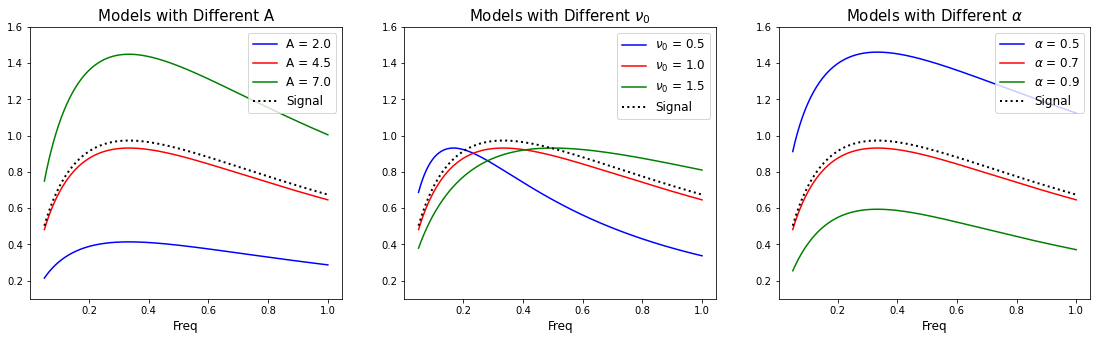

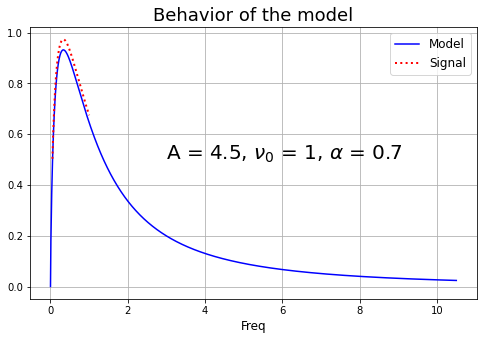

In [2]:
# Q1 Plot different models with given expression of signal

n = 3; cc = ['b','r','g']; Ps = np.array([[4.5]*n*3,[1]*n*3,[0.7]*n*3])
Ps2 = np.array([np.linspace(2,7,n),np.linspace(0.5,1.5,n),np.linspace(0.5,0.9,n)])
Model = []; Labels = ['A',r'$\nu_0$',r'$\alpha$']
# Generate a matrix for parameters
for i in range(n):
  for j in range(n):
    Ps[i,i*3+j] = Ps2[i,j]

# Plot models with different parameters
fig0,ax0 = plt.subplots(1,3,figsize=(19,5))
for i in range(n*3):
  s = lambda x: Ps[0,i]*(x/Ps[1,i])**Ps[2,i] * (1+x/Ps[1,i])**(-4*Ps[2,i])
  Model.append(s(freq))
  ax0[i//n].plot(freq,Model[i],c=cc[i%n],label='{:s} = {:.1f}'.format(Labels[i//n],Ps[i//n][i]))
  ax0[i//n].set_title('Models with Different {:s}'.format(Labels[i//n]),fontsize=15)
for i in range(3):
  ax0[i].set_xlabel('Freq',fontsize=12)
  ax0[i].plot(freq,Signal,c='k',lw=2,linestyle=':',label='Signal')
  ax0[i].set_ylim([0.1,1.6]); ax0[i].legend(fontsize=12,loc='upper right')

# Plot the behavior of model at small and large freq
plt.figure(figsize=(8,5)); plt.title('Behavior of the model',fontsize=18)
s = lambda x: 4.5*(x)**0.7 * (1+x)**(-2.8)
freq1 = np.linspace(1e-5,10.5,1000)
plt.plot(freq1,s(freq1),c='b',label='Model')
plt.plot(freq,Signal,c='r',lw=2,linestyle=':',label='Signal')
plt.xlabel('Freq',fontsize=12); plt.grid(); plt.legend(fontsize=12)
plt.text(3,0.5,r'A = 4.5, $\nu_0$ = 1, $\alpha$ = 0.7',fontsize=20)

print(' ')

At first, we changed one parameter at one time, and we can see the main effect of $A$ and $α$ is to move the curve vertically, and the effect of $\nu_0$ seems more complicated.

* As a linear parameter, the larger the value of $A$ is, the higher the curve moves, which can be seen in the above plot.

* $\alpha$ is on the exponents, if all the parameters and frequency is positive numbers, since the denominator $(1+\nu_i/\nu_0)^{4\alpha}$ is always larger, the amplitude of the signal will be lower as $\alpha$ becomes larger. This can be seen in the plot. 

* As $\nu_0$ appears both in the numerator and denominator, it is hard to intuitively predict the behavior of the function with different $\nu_0$. But from the plot we find the position of maxima moves from left to right as $\nu_0$ increases. Also, we can find the shape of the curved changed as $\nu_0$ varies. However, the change of $\nu_0$ does not effect the maximum amplitude of the signal.

After several attempts, we find around $(4.5, 1.0, 0.7)_{A,\nu_0,\alpha}$, the model overlaps well with the truth signal and we plotted the behavior of this model when $\nu \ll \nu_0$ and $\nu \gg \nu_0$. In both cases, the signal will approach 0, which is in line with our expectation as the denominator $(1+\nu_i/\nu_0)^{4\alpha}$ has $\nu$ with larger exponents.

## **2. Newton Raphson’s optimization for ML esitmate of the parameters**

The likelihood function of the data given parameters is

$$ {\cal L} \left( \vec x | \vec \theta \right) = (2\pi \sigma^2)^{-\frac{N}{2}} \exp \left( - \frac{1}{2\sigma^2} \sum_{i=1}^N \left[ x_i - A \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 4 \alpha} \right]^2 \right) $$

$$ \ln {\cal L} \left( \vec x | \vec \theta \right) = -\frac{N}{2}\ln{(2\pi \sigma^2)}  - \frac{1}{2\sigma^2} \sum_{i=1}^N \left[ x_i - A \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 4 \alpha} \right]^2 $$

To get the maximum likelihood estimator, we need to find the expression of the estimator which satisfies $\frac{\partial \ln {\cal L} ( \vec x | \vec \theta )}{\partial \vec \theta} = 0$, in other words, find the roots of this equation. Since we have three parameters to be estimated, we need to solve three equation, namely

$$\frac{\partial \ln {\cal L} ( \vec x | \vec \theta )}{\partial A} = -\frac{1}{\sigma^2} \sum_{i=1}^N \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha} \left( A \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} - x_i \left( 1 + \frac{\nu_i}{\nu_0} \right)^{ 4 \alpha}  \right) = 0$$

$$ \frac{\partial \ln {\cal L} ( \vec x | \vec \theta )}{\partial \nu_0} = \frac{A \alpha}{\sigma^2}  \sum_{i=1}^N \frac{\nu_0 - 3 \nu_i}{\nu_0^2 + \nu_0 \nu_i } \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha} \left( A \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} - x_i \left( 1 + \frac{\nu_i}{\nu_0} \right)^{ 4 \alpha}  \right) = 0 $$

\begin{gather*}
    \frac{\partial \ln {\cal L} ( \vec x | \vec \theta )}{\partial \alpha} = -\frac{A}{\sigma^2} \sum_{i=1}^N \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha}  \left( \ln \left( \frac{\nu_i}{\nu_0} \right) - 4 \ln \left( 1 + \frac{\nu_i}{\nu_0} \right) \right) \\
    \left( A \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} - x_i \left( 1 + \frac{\nu_i}{\nu_0} \right)^{ 4 \alpha}  \right) = 0
\end{gather*}

For $A$, the linear parameter, we can get an expression for its ML estimator, containing the other two parameters, $\nu_0$ and $\alpha$

$$ \hat A = \frac{\sum_{i=1}^N x_i \left( 1 + \frac{\nu_i}{\nu_o} \right)^{ 4 \alpha}}{\sum_{i=1}^N \left( \frac{\nu_i}{\nu_o} \right)^{\alpha}} $$

As for the two nonlinear parameters,  $\nu_0$ and $\alpha$, we are unable to find such expression for their ML estimator, but still, we can try to get the ML estimates numerically. Here, we will use Newton-Raphson iteration to find the roots of the equations.

Since the parameters of the model are not independent, they are correlated to the others, so we need to solve multiple varibles simutaneously. Therefore, the Newton Raphson iterative step would be $\Theta_f = \Theta_i - J^{-1}F(A_i,\nu_{0i},\alpha_i)$, where $\Theta = [A, \nu_0,\alpha]^T$ and

$$ F(A_i,\nu_{0i},\alpha_i) = \begin{pmatrix} \frac{\partial \ln {\cal L} ( \vec x | \vec \theta )}{\partial A} \\ \frac{\partial \ln {\cal L} ( \vec x | \vec \theta )}{\partial \nu_o} \\  \frac{\partial \ln {\cal L} ( \vec x | \vec \theta )}{\partial \alpha} \end{pmatrix}, \,\,{\rm and \,\,} J = \begin{pmatrix} \frac{\partial^2 \ln {\cal L}}{\partial A^2} & \frac{\partial^2 \ln {\cal L}}{\partial A \partial \nu_o} & \frac{\partial^2 \ln {\cal L}}{\partial A \partial \alpha} \\ \frac{\partial^2 \ln {\cal L} }{\partial \nu_o \partial A} & \frac{\partial^2 \ln {\cal L} }{\partial \nu_o^2} & \frac{\partial^2 \ln {\cal L} }{\partial \nu_o \partial \alpha} \\ \frac{\partial^2 \ln {\cal L} }{\partial \alpha \partial A} & \frac{\partial^2 \ln {\cal L} }{\partial \alpha \partial \nu_o} & \frac{\partial^2 \ln {\cal L} }{\partial \alpha^2} \end{pmatrix} $$

Analytically, we can derive the expression of the second derivatives of logrithm of the likehood function. Noteworthily, the symmetry of second partial derivatives holds true for our likelihood function, so we need the following six second derivatives for the NR step.

$$ \frac{\partial^2 \ln {\cal L} ( \vec x | \vec \theta )}{\partial A^2} = -\frac{1}{\sigma^2} \sum_{i=1}^N \left( \frac{\nu_i}{\nu_0} \right)^{2\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha} $$

\begin{gather*}
    \frac{\partial \ln {\cal L} ( \vec x | \vec \theta )}{\partial \nu_0^2 } = \frac{\alpha A}{\sigma^2}  \sum_{i=1}^N \frac{1}{\nu_0^2 ( \nu_0 + \nu_i )^2 } \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha} \\
    \Biggr[ x_i \left( 1 + \frac{\nu_i}{\nu_0} \right)^{ 4 \alpha} \left( (9 \alpha - 3 ) \nu_i^2 - 6 ( \alpha + 1 ) \nu_0 \nu_i + ( \alpha + 1 ) \nu_0^2 \right) \\
    - A \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} \left( 3 ( 6 \alpha - 1 ) \nu_i^2 - 6 ( 2 \alpha + 1 ) \nu_0 \nu_i + ( 2 \alpha + 1 ) \nu_0^2 \right) \Biggr]
\end{gather*}

\begin{gather*}
     \frac{\partial \ln {\cal L} ( \vec x | \vec \theta )}{\partial \alpha^2 } = -\frac{A}{\sigma^2}  \sum_{i=1}^N \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha}  \left( \ln \left( \frac{\nu_i}{\nu_0} \right) - 4 \ln \left( 1 + \frac{\nu_i}{\nu_0} \right) \right)^2 \\
     \left( 2 A \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} - x_i \left( 1 + \frac{\nu_i}{\nu_0} \right)^{ 4 \alpha}  \right)
\end{gather*}

----------------------------

\begin{gather*}
    \frac{\partial^2 \ln {\cal L} ( \vec x | \vec \theta )}{\partial A \partial \nu_0} = \frac{\alpha}{\sigma^2} \sum_{i=1}^N \frac{\nu_0 - 3 \nu_i}{\nu_0^2 + \nu_0 \nu_i } \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha} 
    \left( 2 A \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} - x_i \left( 1 + \frac{\nu_i}{\nu_0} \right)^{ 4 \alpha}  \right)
\end{gather*}

\begin{gather*}
    \frac{\partial^2 \ln {\cal L} ( \vec x | \vec \theta )}{\partial A \partial \alpha} = -\frac{1}{\sigma^2} \sum_{i=1}^N \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha} \left( \ln \left( \frac{\nu_i}{\nu_0} \right) - 4 \ln \left( 1 + \frac{\nu_i}{\nu_0} \right) \right) \\
    \left( 2 A \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} - x_i \left( 1 + \frac{\nu_i}{\nu_0} \right)^{ 4 \alpha}  \right)
\end{gather*}

\begin{gather*}
    \frac{\partial \ln {\cal L} ( \vec x | \vec \theta )}{\partial \nu_0 \partial \alpha} = \frac{1}{\sigma^2}  \sum_{i=1}^N \frac{\nu_0 - 3 \nu_i}{\nu_0^2 + \nu_0 \nu_i } \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha} \\
    \Biggr[ \alpha \left( \ln \left( \frac{\nu_i}{\nu_0} \right) - 4 \ln \left( 1 + \frac{\nu_i}{\nu_0} \right) \right) \left( 2 A \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} - x_i \left( 1 + \frac{\nu_i}{\nu_0} \right)^{ 4 \alpha}  \right) \\
    + A \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} - x_i \left( 1 + \frac{\nu_i}{\nu_0} \right)^{ 4 \alpha} \Biggr]
\end{gather*}

---------------------

Numerically, we just need to plug in the numbers in the above matrix, then we can get the NR iterative step, however, such step would be too large to result in undesirable oscillation of the result and cannot get a good approximation of the roots.

Therefore, we need an extra coefficients $\lambda \in (0,1)$ for the NR step. In the below cell, we tried a 270 steps NR optimization, with $\lambda = 0.05$.


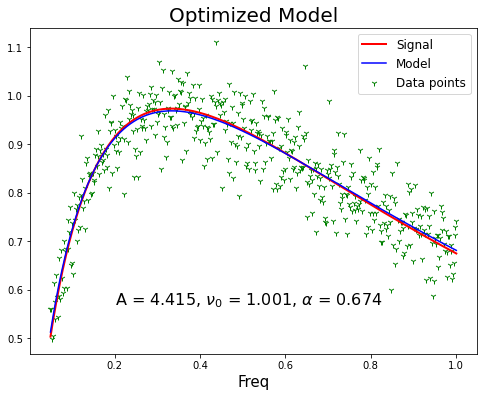

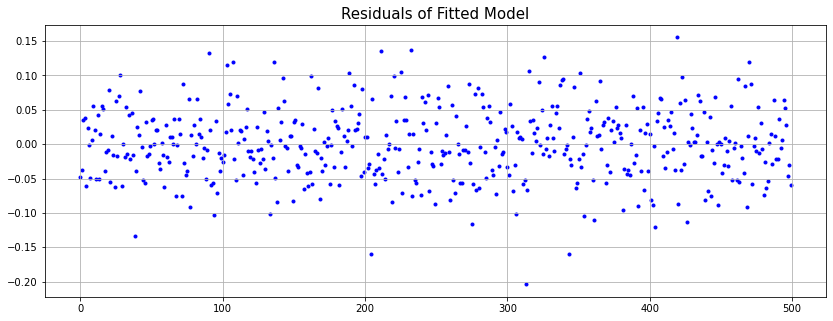

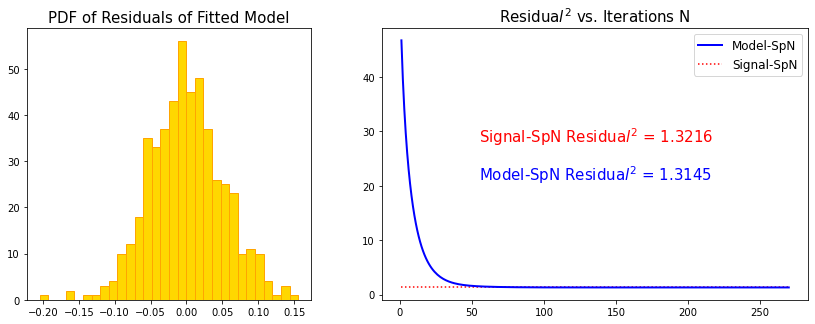

In [5]:
# Q2 Run the NR optimization and plot the model

sgm = 0.05; data = SpN; N = 270; r = 0.05
thetas,derivs,erds = NR_optimization(freq,data,sgm,N,r)
n_axis = np.arange(1,N+1); cc = ['r','b','g']

Af = thetas[0][-1]; nuf = thetas[1][-1]; alf = thetas[2][-1]
s = lambda x: Af * (x/nuf) ** alf * (1 + x/nuf)**(-4*alf)
Cal = s(freq)

fig1 = plt.figure(figsize=(8,6))
plt.title('Optimized Model',fontsize=20); plt.xlabel('Freq',fontsize=15)
plt.plot(freq,Signal,c='r',lw=2,label='Signal'); plt.plot(freq,Cal,c='b',label='Model')
plt.scatter(freq,SpN,c='g',marker='1',lw=1,label='Data points')
plt.legend(fontsize=12,loc='upper right')
plt.text(0.2,0.57,r'A = {:.3f}, $\nu_0$ = {:.3f}, $\alpha$ = {:.3f}'.format(Af,nuf,alf),fontsize=16)

# Plots of residuals
fig5,ax3 = plt.subplots(figsize=(14,5))
ax3.scatter(range(500),Cal-SpN,marker='.',c='b',lw=1); ax3.grid()
ax3.set_title('Residuals of Fitted Model',fontsize=15)

fig4,ax2 = plt.subplots(1,2,figsize=(14,5),gridspec_kw={'width_ratios':[2,3]})
ax2[0].hist(Cal-SpN,bins=30,color='gold',edgecolor='orange')
ax2[0].set_title('PDF of Residuals of Fitted Model',fontsize=15)

ax2[1].set_title(r'Residua$l^2$ vs. Iterations N',fontsize=15)
er1 = np.sum((SpN - Signal)**2)
ax2[1].hlines(er1,1,N,color='r',linestyles=':',label='Signal-SpN')
ax2[1].plot(n_axis,erds,c='b',lw=2,label='Model-SpN'); ax2[1].legend(fontsize=12)
ax2[1].text(55,21,r'Model-SpN Residua$l^2$ = {:.4f}'.format(np.min(erds)),color='b',fontsize=15)
ax2[1].text(55,28,r'Signal-SpN Residua$l^2$ = {:.4f}'.format(er1),color='r',fontsize=15)

print(' ')

After the NR optimization, there is a very good overlap between our fitted model and the truth signal shown in the first plot above. And there is also an acceptable Gaussian distribution of residuals between the finally fitted model and the data points, which is obvious in the PDF of the residuals.

Futhermore, we also find that the residuals between the data points and fitted model drops rapidly over the first 50 iterations with $\lambda = 0.05$. And finally, the residuals between the data points and fitted model is even lower than that between the truth signal and the data points, which indicates that we obtained a precise model for the given data set, but our model might capture certain characteristic of this particular data set, and deviate a little bit from the real signal. To get rid of such deviation, we need a larger data set, and thus the fitted model can reflect the signal more accurately.

In addition, we also plotted the traces of the parameters and the value of first derivatives of the likelihood function, as the iteration steps increases. Taking all the infomation together, we can conclude that a large iteration number is not necessary, the latter steps do not contribute significantly to the increase of model precision.

Also, based on several attempts, we found that there is a negative correlation between the iteration steps N and the coefficient $\lambda$, in a certain range of $\lambda$, the larger the value of $\lambda$, the faster we can reach a steady roots.

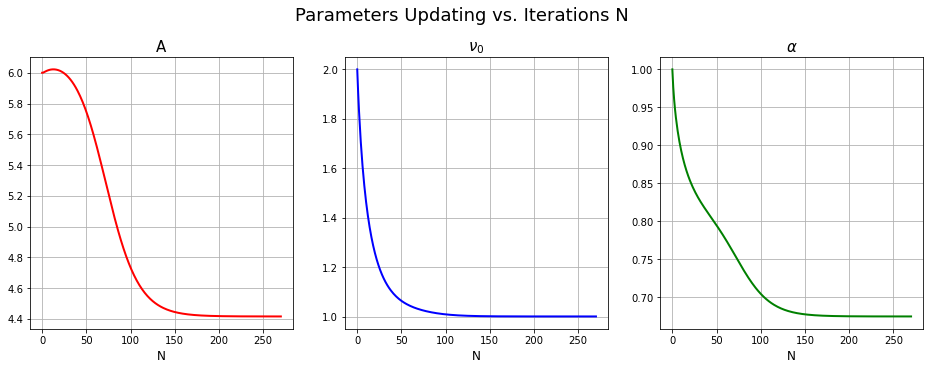

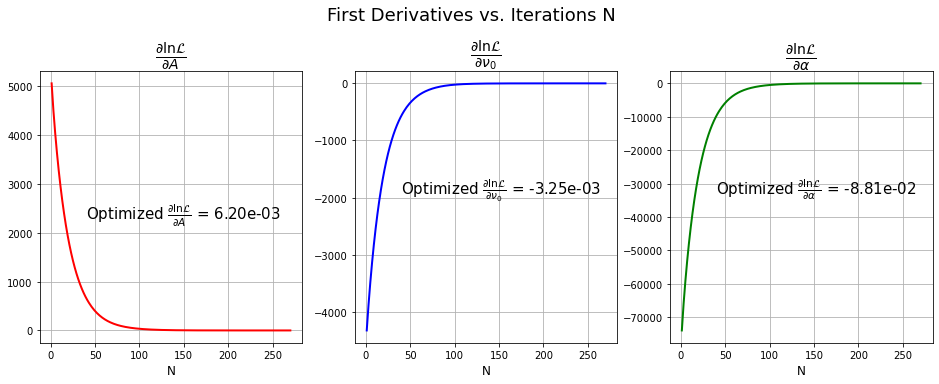

In [5]:
# Plot the Parameter updating traces
fig3,ax1 = plt.subplots(1,3,figsize=(16,5))
fig3.suptitle('Parameters Updating vs. Iterations N',fontsize=18,y=1.02)
for i in range(3):
  ax1[i].plot(thetas[i,:],c=cc[i],lw=2); ax1[i].set_xlabel('N',fontsize=12)
  ax1[i].grid(); ax1[i].set_title(Labels[i],fontsize=15)

# Plots of first derivatives
fig2,ax = plt.subplots(1,3,figsize=(16,5)); cc = ['r','b','g']
Titles_d = [r'$\frac{\partial \ln{\cal L}}{\partial A}$',
            r'$\frac{\partial \ln{\cal L}}{\partial \nu_0}$',
            r'$\frac{\partial \ln{\cal L}}{\partial \alpha}$']
fig2.suptitle('First Derivatives vs. Iterations N',fontsize=18,y=1.06)
for i in range(3):
  ax[i].plot(n_axis,derivs[i,1:],c=cc[i],lw=2); ax[i].set_xlabel('N',fontsize=12)
  ax[i].set_title(Titles_d[i],fontsize=20); ax[i].grid()
  ax[i].text(40,0.45*derivs[i,1]+derivs[i,-1],'Optimized {:s} = {:.2e}'.format(Titles_d[i],derivs[i,-1]),fontsize=15)

print(' ')

## **3. Monte Carlo simulations for the PDFs of estimated parameters**

Based on given signal data, we can generate more sets of data by simply adding the WGN to the signal, and such MC simulation can let us to produce the PDFs of the estimates, and estimate the parameters of the signal more accurately.

Here we generated $10^4$ sets of data and found the ML estimates with the previous NR optimization method.

Before implementing the simulation, we need to find out an appropriate iteration number, or tolerance of NR method, which can guarantee the precision of the fitted model and is not too computationally costly.

In the below cell, we tried 20 NR iterations with different value of $\lambda$ and found that we can get a steady solution using $\lambda > 0.2$, and the most precise model are found with $\lambda = 0.4$, which will be used in the following MC simulation.


With 20 iterations, the best NR step is r = 0.40

The minimum residue is Err = 1.3145




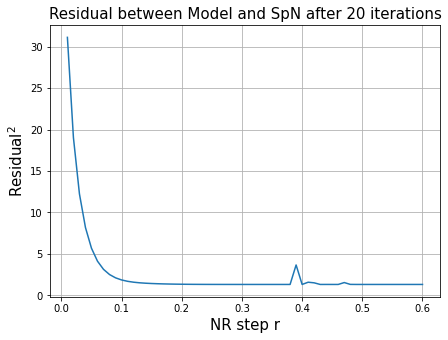

In [6]:
# Finding the best iteration time and r value

sgm = 0.05; data = SpN; N = 20
r = np.arange(0.01,0.61,0.01); Er1 = np.array([])

for each in r:
  thetas,derivs,erds = NR_optimization(freq,data,sgm,N,each)
  Er1 = np.append(Er1,np.min(erds))

plt.figure(figsize=(7,5)); plt.plot(r,Er1); plt.grid()
plt.title('Residual between Model and SpN after 20 iterations',fontsize=15)
plt.xlabel('NR step r',fontsize=15); plt.ylabel(r'Residual$^2$',fontsize=15)

print('\nWith 20 iterations, the best NR step is r = {:.2f}'.format(r[np.where(Er1==np.min(Er1))][0]))
print('\nThe minimum residue is Err = {:.4f}\n\n'.format(np.min(Er1)))

In [ ]:
# Q3 Calculation

times = 10**4; i = 0; parameters_array = np.array([])
up = np.array([5.6,1.2,0.9]); low = np.array([3.8,0.8,0.5])
while i < times:
  data = Signal + np.random.normal(0,sgm2,500)
  thetas,derivs,erds = NR_optimization(freq,data,sgm)
    # avoid collecting problematic data points encountered by overflows
  checkup = thetas[:,-1]>up; checklow = thetas[:,-1]<low
  if checkup.any() or checklow.any() or np.isnan(thetas[0,-1]):
    continue
  else:
    i += 1
    parameters_array = np.append(parameters_array,thetas[:,-1])
  if i%1000 == 0 or i == 100: print(i)

result = np.reshape(parameters_array,(times,3))

fileObject = open("Q3_MC_Paras_1",'wb')
pickle.dump(result,fileObject)
fileObject.close() 

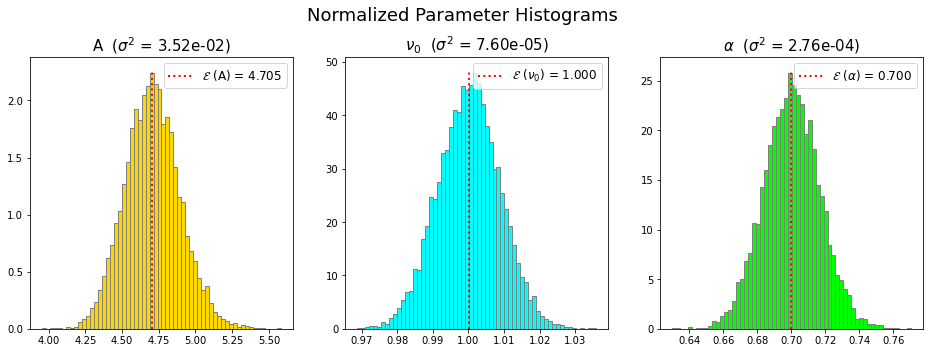

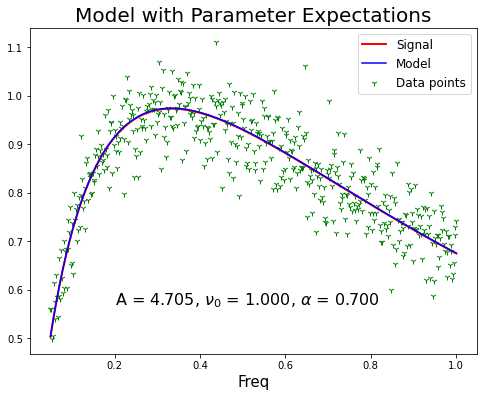

In [2]:
# Q3 Plot PDFs of parameters

fileObject = open("Q3_MC_Paras_1",'rb')
result = pickle.load(fileObject)
fileObject.close()

fig1,ax1 = plt.subplots(1,3,figsize=(16,5))
fig1.suptitle('Normalized Parameter Histograms',fontsize=18,y=1.02)
cc = ['gold','cyan','lime']; Labels = ['A',r'$\nu_0$',r'$\alpha$']
Expects = np.array([])
Vars = np.array([])

for i in range(3):
  Expects = np.append(Expects, np.mean(result[:,i]))
  Vars = np.append(Vars, np.var(result[:,i]))
  h = ax1[i].hist(result[:,i],bins=60,color=cc[i],edgecolor='grey',density=True)
  ax1[i].vlines(Expects[i],0,np.max(h[0])*1.01,color='r',lw=2,linestyles=':',label=r'$\cal E$ ({:s}) = {:.3f}'.format(Labels[i],Expects[i]))
  ax1[i].set_title('{:s}  ($\sigma^2$ = {:.2e})'.format(Labels[i],Vars[i]),fontsize=15); ax1[i].legend(fontsize=12)

Exp_Sig = Expects[0]*(freq/Expects[1])**Expects[2]*(1+freq/Expects[1])**(-4*Expects[2])
fig2 = plt.figure(figsize=(8,6))
plt.title('Model with Parameter Expectations',fontsize=20); plt.xlabel('Freq',fontsize=15)
plt.plot(freq,Signal,c='r',lw=2,label='Signal'); plt.plot(freq,Exp_Sig,c='b',label='Model')
plt.scatter(freq,SpN,c='g',marker='1',lw=1,label='Data points')
plt.legend(fontsize=12,loc='upper right')
plt.text(0.2,0.57,r'A = {:.3f}, $\nu_0$ = {:.3f}, $\alpha$ = {:.3f}'.format(Expects[0],Expects[1],Expects[2]),fontsize=16)
  
print(' ')

After $10^4$ MC simulations, we got the expectations and variances of the parameters. They are slightly different from what we got from the first data set SpN, which is in line with our expectation.

When we plot model with the expectation parameters, we can clearly see there is a better overlap between the expectation model and the truth signal, because larger amount of data helps us to approach the truth value.

## **4. Fisher information matrix and CRLB matrix for ML estimates**

The **Fisher Information matrix** is defined as 

$$ \boxed{   J_{ij} \equiv - {\cal E}\left[  \frac{\partial^2 \ln {\cal L}(\vec x | \vec \theta)}{\partial \theta_i \partial \theta_j}  \right] } = - {\cal E} \begin{pmatrix} \frac{\partial^2 \ln {\cal L}}{\partial A^2} & \frac{\partial^2 \ln {\cal L}}{\partial A \partial \nu_o} & \frac{\partial^2 \ln {\cal L}}{\partial A \partial \alpha} \\ \frac{\partial^2 \ln {\cal L} }{\partial \nu_o \partial A} & \frac{\partial^2 \ln {\cal L} }{\partial \nu_o^2} & \frac{\partial^2 \ln {\cal L} }{\partial \nu_o \partial \alpha} \\ \frac{\partial^2 \ln {\cal L} }{\partial \alpha \partial A} & \frac{\partial^2 \ln {\cal L} }{\partial \alpha \partial \nu_o} & \frac{\partial^2 \ln {\cal L} }{\partial \alpha^2} \end{pmatrix} $$

which is the very similar to the Jacobian matrix we used in the NR optimization. The only difference is to take the negative expectation of the Jacobian matrix.

When we take a closer look to the expressions of each element in the above Jacobian matrix, we can find that all the $x_i$ are linear term, whose expectation is just the corresponding coefficient times the expectation of $x_i$, and we have ${\cal E}(x_i) = s_i$.

For $ \frac{\partial^2 \ln {\cal L} ( \vec x | \vec \theta )}{\partial A^2} $, there is no $x_i$ term involved, so it keep the same as in Jacobian matrix, and the rest are listed below.

$$ \frac{\partial^2 \ln {\cal L} ( \vec x | \vec \theta )}{\partial A^2} = -\frac{1}{\sigma^2} \sum_{i=1}^N \left( \frac{\nu_i}{\nu_0} \right)^{2\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha} $$

\begin{gather*}
   {\cal E}\left( \frac{\partial \ln {\cal L} ( \vec x | \vec \theta )}{\partial \nu_0^2 } \right) = \frac{\alpha A^2}{\sigma^2}  \sum_{i=1}^N \frac{ - 9 \alpha \nu_i^2 + 6 \alpha \nu_0 \nu_i - \alpha \nu_0^2 }{\nu_0^2 ( \nu_0 + \nu_i )^2 } \left( \frac{\nu_i}{\nu_0} \right)^{2\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha} 
\end{gather*}

\begin{gather*}
     {\cal E}\left( \frac{\partial \ln {\cal L} ( \vec x | \vec \theta )}{\partial \alpha^2 }\right) = -\frac{A^2}{\sigma^2}  \sum_{i=1}^N \left( \frac{\nu_i}{\nu_0} \right)^{2\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha}  \left( \ln \left( \frac{\nu_i}{\nu_0} \right) - 4 \ln \left( 1 + \frac{\nu_i}{\nu_0} \right) \right)^2 
\end{gather*}

----------------------------

\begin{gather*}
    {\cal E}\left( \frac{\partial^2 \ln {\cal L} ( \vec x | \vec \theta )}{\partial A \partial \nu_0}\right) = \frac{A \alpha}{\sigma^2} \sum_{i=1}^N \frac{\nu_0 - 3 \nu_i}{\nu_0^2 + \nu_0 \nu_i } \left( \frac{\nu_i}{\nu_0} \right)^{2 \alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha} 
\end{gather*}

\begin{gather*}
    {\cal E}\left( \frac{\partial^2 \ln {\cal L} ( \vec x | \vec \theta )}{\partial A \partial \alpha}\right) = -\frac{A}{\sigma^2} \sum_{i=1}^N \left( \frac{\nu_i}{\nu_0} \right)^{2 \alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha} \left( \ln \left( \frac{\nu_i}{\nu_0} \right) - 4 \ln \left( 1 + \frac{\nu_i}{\nu_0} \right) \right) 
\end{gather*}

\begin{gather*}
    {\cal E}\left( \frac{\partial \ln {\cal L} ( \vec x | \vec \theta )}{\partial \nu_0 \partial \alpha}\right) = \frac{A \alpha}{\sigma^2}  \sum_{i=1}^N \frac{\nu_0 - 3 \nu_i}{\nu_0^2 + \nu_0 \nu_i } \left( \frac{\nu_i}{\nu_0} \right)^{2 \alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 8 \alpha} \left( \ln \left( \frac{\nu_i}{\nu_0} \right) - 4 \ln \left( 1 + \frac{\nu_i}{\nu_0} \right) \right) 
\end{gather*}

----------------------------

By plugging the values of ${\cal E}(A)$, ${\cal E}(\nu_0)$ and ${\cal E}(\alpha)$ and frequency $\vec \nu$ into these expressions, we can get the Fisher information matrix, and its inverse matrix is the CRLB of our estimators.

$$ {\rm var}(\hat \theta) \ge J^{-1}(\vec \theta) = -{\cal E}\left[ \frac{\partial^2 \ln[{\cal L}(\vec x | \vec \theta)]}{\partial \theta^2} \right]^{-1}_{\vec x} $$

The CRLB for the variances of the parameters ${\rm var} (A)$, ${\rm var} (\nu_0)$ and ${\rm var} (\alpha)$ are the diagonal elements of the CRLB matrix respectively.

In the below cell, we calculated the CRLB and compared with the variances we got from MC simulation, all the CRLB is smaller than the variances from MC results, which is in line with the theory of CRLB, because CRLB is the therotically lowest bound for the variances of all the unbiased estimator, and all the numerical simulation result should obey this rule.


In [4]:
# Q4 Calculate CRLB matrix
CRLB_mtx = CRLB(freq,Expects[0],Expects[1],Expects[2],0.05)
np.set_printoptions(precision=3,suppress=False)

print('\n Fisher Information Matrix:')
print(np.linalg.inv(CRLB_mtx))

print('\n CRLB Matrix:')
print(CRLB_mtx)

# Calculate Covariance Matrix
cov_mtx = np.zeros((3,3))
for i in range(3):
  for j in range(3):
    cov_mtx[i,j] = np.sum((result[:,i]-Expects[i])*(result[:,j]-Expects[i]))
cov_mtx /= 10000
print('\n Covariance Matrix:')
print(cov_mtx)

print('\n Variances in covariance matrix')
print(np.diag(cov_mtx))

print('\n CRLB for Variances of parameters')
print(np.diag(CRLB_mtx))


# Compare Variances and CRLB
print('\n Differences between variances and corresponding CRLB:')
print(np.diag(cov_mtx-CRLB_mtx))
if (cov_mtx-CRLB_mtx > 0).any(): print('\n All variances larger than CRLB\n')



 Fisher Information Matrix:
[[  6552.87    5505.3   -74615.656]
 [  5505.3    19695.757 -65258.065]
 [-74615.656 -65258.065 853700.202]]

 CRLB Matrix:
[[3.498e-02 4.719e-04 3.093e-03]
 [4.719e-04 7.436e-05 4.693e-05]
 [3.093e-03 4.693e-05 2.751e-04]]

 Covariance Matrix:
[[3.519e-02 4.493e-04 3.108e-03]
 [4.493e-04 7.599e-05 4.470e-05]
 [3.108e-03 4.470e-05 2.762e-04]]

 Variances in covariance matrix
[3.519e-02 7.599e-05 2.762e-04]

 CRLB for Variances of parameters
[3.498e-02 7.436e-05 2.751e-04]

 Differences between variances and corresponding CRLB:
[2.117e-04 1.627e-06 1.074e-06]

 All variances larger than CRLB



## **5. Likelihood function on 3D grid and Marginalizations**

With the data point SpN, we can also compute the probability density on a 3D grid of $A$, $\nu_0$ and $\alpha$.

$$ {\cal L} \left( \vec x | \vec \theta \right) = (2\pi \sigma^2)^{- N/2} \exp \left( - \frac{1}{2\sigma^2} \sum_{i=1}^N \left[ x_i - A \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 4 \alpha} \right]^2 \right) $$

Here, the normalization constant $ (2\pi \sigma^2)^{- N/2}$ is a very large number and will result in overflow of the program, also, for some grid points far from the center, the exponantial part of the likelihood function is very small and will be automatically rounded to 0 during the calculation. So, here we will only calculate the exponantial part first and normalize the 3D matrix at the end.

With the computed 3D matrix of the probability density of each grid point in hand, we can marginalize the joint PDF and get the 1D PDFs or 2D joint PDFs of the parameters of interest.

$$ P(\vec \theta_1 | \vec x) = \int P(\vec \theta_1, \vec \theta_2 ~|~\vec x) d\vec \theta_2 $$

Below are the plots we got from the integration.

In [ ]:
# Q5 Calculation of 3D PDF

N = 200; mus = thetas[:,-1]; R = np.array([])
for i in range(3):
  R = np.append(R,(np.max(result[:,i])-np.min(result[:,i]))/1.98)

pdf_3d_mtx = PDF_3D(freq,SpN,mus,R,N)

fileObject = open("Q5_PDF_3D_1",'wb')
pickle.dump(pdf_3d_mtx,fileObject)
fileObject.close() 

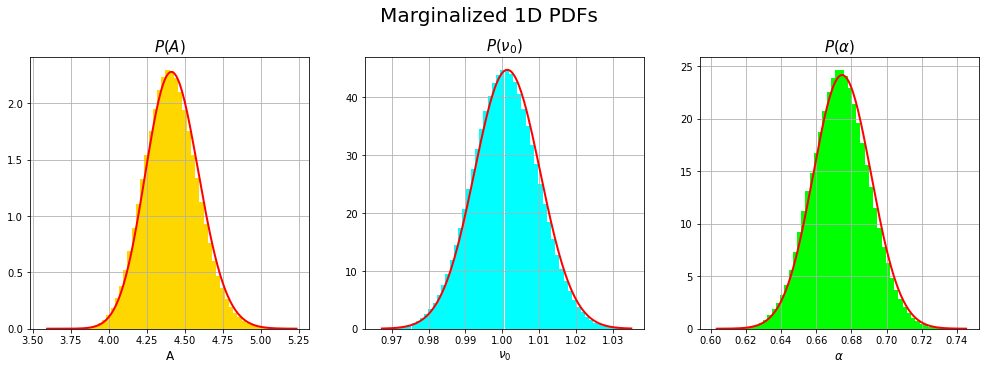

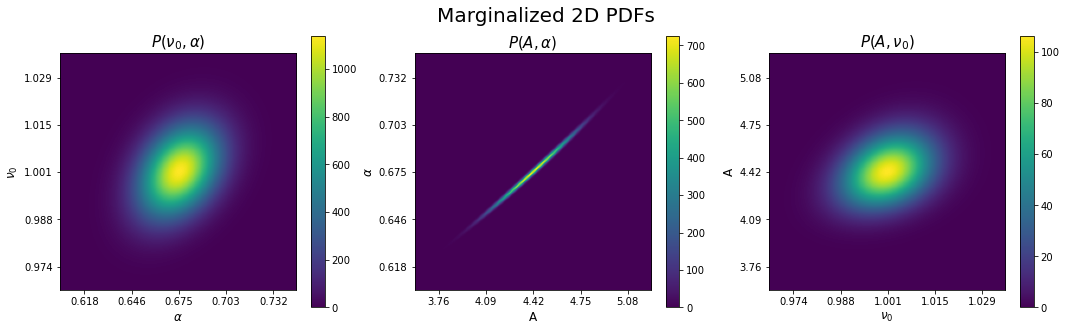

In [3]:
# Q5 Marginalization and Plots

fileObject = open("Q5_PDF_3D_1",'rb')
PDFs_1D,PDFs_2D,axes = pickle.load(fileObject)
fileObject.close()
fileObject = open("Q5_PDF_3D_2",'rb')
his_1D,dump,his_ax = pickle.load(fileObject)
fileObject.close()

N = PDFs_1D[0,:].size; cc = ['gold','cyan','lime']
tick_pos = np.array([int((0.2*i+0.1)*N) for i in range(5)])
tick_label = []; Labels = ['A',r'$\nu_0$',r'$\alpha$']
Titles1 = [r'$P(A)$',r'$P(\nu_0)$',r'$P(\alpha)$']
Titles2 = [r'$P(\nu_0,\alpha)$',r'$P(A,\alpha)$',r'$P(A,\nu_0)$']

# Plot 1D PDFs
fig3,ax1 = plt.subplots(1,3,figsize=(17,5))
fig3.suptitle('Marginalized 1D PDFs',fontsize=20,y=1.02)
for i in range(3):
  plt.sca(ax1[i]); plt.xlabel(Labels[i],fontsize=12)
  plt.plot(axes[i],PDFs_1D[i,:],c='r',lw=2); wid = his_ax[i][1]-his_ax[i][0]
  plt.bar(his_ax[i]-wid/2,his_1D[i,:],color=cc[i],width=wid)
  plt.title(Titles1[i],fontsize=15); plt.xlabel(Labels[i],fontsize=12)
  plt.grid(); tick_label.append(np.around(axes[i][tick_pos],3))
  
# Plot 2D PDFs
fig4,ax2 = plt.subplots(1,3,figsize=(18,5))
fig4.suptitle('Marginalized 2D PDFs',fontsize=20,y=0.96)
for i in range(3):
  plt.sca(ax2[i])
  plt.imshow(PDFs_2D[i,:,:]);plt.colorbar()
  plt.yticks(np.flip(tick_pos),tick_label[(i+1)%3]); plt.ylabel(Labels[(i+1)%3],fontsize=12)
  plt.xticks(tick_pos,tick_label[(i+2)%3]); plt.xlabel(Labels[(i+2)%3],fontsize=12)
  plt.title(Titles2[i],fontsize=15)

print(' ')

At first, we note that all the 1D PDFs are centered on the values of parameters we got from NR optimizatio in Q2, which makes sense, because the values we got in Q2 should be the ML estimates, in the other words, the corresponding grid point on the 3D grid here should have the highest probability density.

Another intersting result is the 2D joint PDF of $A$ and $\alpha$, there is a very strong correlation between these two parameters. We can infer this relation from both plots in Q1, for instance, a large $A$ will lead to the model curve move upwards along the amplitude axis, therefore, to keep the model still fitted to the data points, we need a larger $\alpha$ value to counter such movement.

We can also see this by compring the expectations from MC simulations and the single estimation of the given data set SpN. We have already seen the expectations from MC gives a better model to describe the signal, whereas the result from Q2 can fit the data set SpN more precise that the signal, but deviate a little bit from the truth signal. This single estimation in Q2 gives smaller $A$ as well as smaller $\alpha$ than the expectations. In this way $A$ and $\alpha$ can compensate each other and results in a pretty good model for the given data set.

Besides, we can also see there are weak correlations between $\nu_0$ and the other two parameters. But there is no such compensation relationship between the other two parameters, so the joint PDFs are more spreaded.

## **6. Markov Chain Monte Carlo for the PDFs of estimates**

We also tried the MCMC method to obtain $10^5$ data points and plotted the resulted PDFs below.

Here we sampled the posterior $Pr(A,\nu_0,\alpha | \vec X)$ assming a flat prior $P(A,\nu_0,\alpha)$, which indicates $Pr(A,\nu_0,\alpha | \vec X) = {\cal L}(\vec X| A,\nu_0,\alpha) $. Then we can use the previous likelihood function to calculate the probability density of a generated parameter set.

$$ {\cal P} \left( \vec \theta | \vec x \right) = {\cal L} \left( \vec x | \vec \theta \right) = (2\pi \sigma^2)^{-\frac{N}{2}} \exp \left( - \frac{1}{2\sigma^2} \sum_{i=1}^N \left[ x_i - A \left( \frac{\nu_i}{\nu_0} \right)^{\alpha} \left( 1 + \frac{\nu_i}{\nu_0} \right)^{- 4 \alpha} \right]^2 \right) $$

The **Metropolis Ratio** of MCMC is defined as

$$ r = \frac{P(\vec q | \vec x) P(\vec p_i | \vec q)}{ P(\vec p_i | \vec x) P(\vec q | \vec p_i)} $$

In case the proposal distribution function is symmetric, i.e. $P(\vec p_i | \vec q) =  P(\vec q | \vec p_i)$ as the case in the above examples, this reduces to 

$$ \boxed{r = \frac{P(\vec q | \vec x)}{ P(\vec p_i | \vec x)}} $$

Given that our proposal distribution function here is a symmetric Gaussian function, so we can use the above simplified version of the Metropolis ratio. 

However, the value of exponents will be 0 at our initial guess because of the large residuals betweem initial guess and the data set, and this $P(\vec p_i | \vec x) = 0$ will be the denominator in the next step, and apparently will give an error, so we cannot directly use this probability to calculate the metropolis ratio. Also, the constant in front of the exponents will be a very large number, which is also problematic.

Instead, it is not hard to find that the metropolis ratio can be written as
$$ r = \frac{P(\vec q | \vec x)}{ P(\vec p_i | \vec x)} = \frac{\exp \left( - \frac{1}{2\sigma^2} \sum_{i=1}^N \left[ x_i - A_q \left( \frac{\nu_i}{\nu_q} \right)^{\alpha_q} \left( 1 + \frac{\nu_i}{\nu_q} \right)^{- 4 \alpha_q} \right]^2 \right) }{\exp \left( - \frac{1}{2\sigma^2} \sum_{i=1}^N \left[ x_i - A_p \left( \frac{\nu_i}{\nu_p} \right)^{\alpha_p} \left( 1 + \frac{\nu_i}{\nu_p} \right)^{- 4 \alpha_p} \right]^2 \right) }  $$

Here, we represent our model points as $\vec m_p$ and $\vec m_q$, then the above metropolis ratio can be written as

$$ r = \exp \left( \frac{1}{2\sigma^2} \left[( \vec x - \vec m_p )^T ( \vec x - \vec m_p ) - ( \vec x - \vec m_q )^T ( \vec x - \vec m_q ) \right] \right) $$

In this way, we can avoid the problems mentioned above, however, the actually calculation, we still can encounter some overflows in the exponantial calculation because the fitted model has very small residuals, which cannot give a valid number for the transional kernel as well.

Given the logorithm is monotonicly increasing on the positive real axis, we can further take the logorithm of our metropoli ratio for the determination of acceptance. And thus we have the **transition kernel** as 

$$ K(\vec p_{i+1} | \vec p_i) = {\rm min}(\log r, 0)$$

For a generated parameter set $\vec q$ :

* If $\log r > 0$ then it will be accepted and stored in the list of all accepted values $\vec p_{i+1} = \vec q$. 

* $\log r < 0$ then we draw a random number $u \sim {\rm unif(0,1)}$ uniformly  between 0 and 1.

  In case $\log u < \log r$, this parameter set can also be accepted.

  If $u> r$, then we draw another sample $\vec q$ from $P_t(\vec q | \vec p_i)$.

With the above decribed algorithm, we can start the MCMC simulation.


In [4]:
# Q6 MCMC fitting calculation

MC_result = MCMC_fit(freq,SpN,Vars,10**5)

fileObject = open("Q6_MCMC_2",'wb')
pickle.dump(MC_result,fileObject)
fileObject.close() 

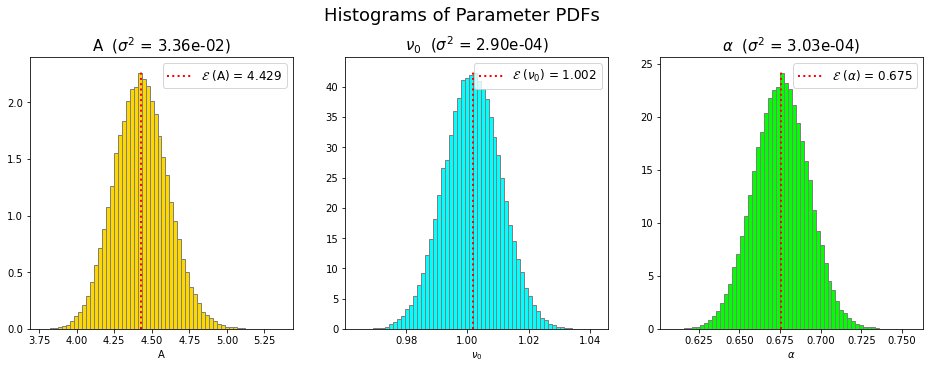

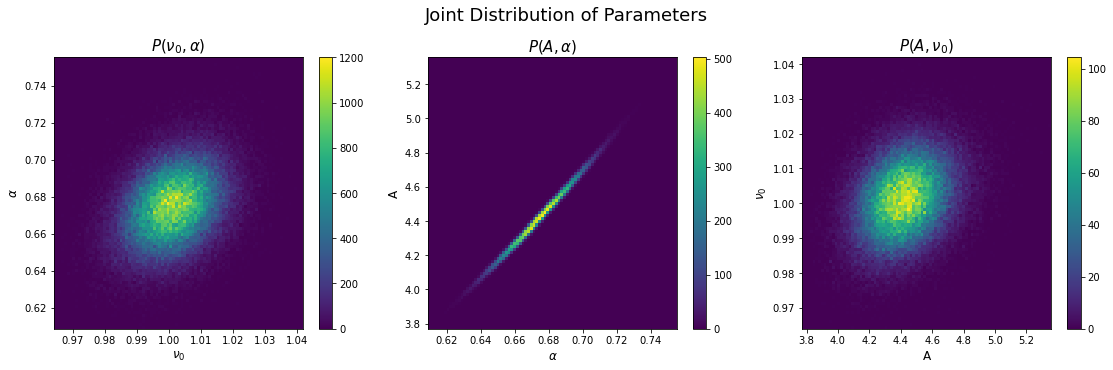

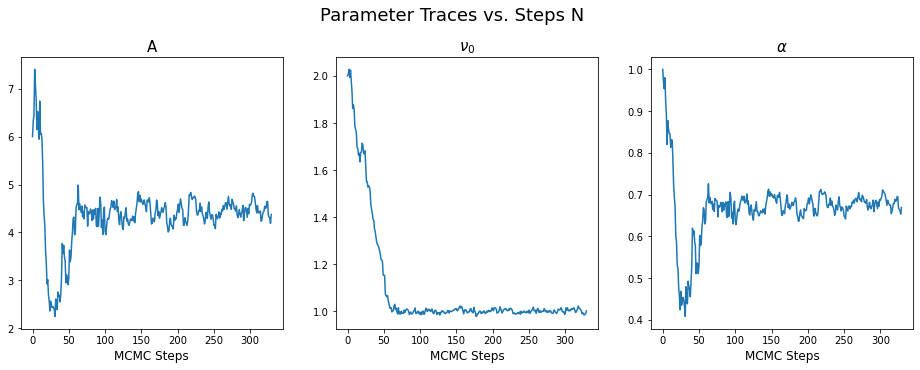

In [4]:
fileObject = open("Q6_MCMC_2",'rb')
para_trace,m_array = pickle.load(fileObject)
fileObject.close()

Exp_MC = np.array([]); Var_MC = np.array([]); cc = ['gold','cyan','lime']

fig6,ax1 = plt.subplots(1,3,figsize=(16,5))
fig6.suptitle('Histograms of Parameter PDFs',fontsize=18,y=1.02)
fig7,ax2 = plt.subplots(1,3,figsize=(19,5))
fig7.suptitle('Joint Distribution of Parameters',fontsize=18,y=1.02)
fig8,ax3 = plt.subplots(1,3,figsize=(16,5))
fig8.suptitle('Parameter Traces vs. Steps N',fontsize=18,y=1.02)

stp = 60

for i in range(3):
  Exp_MC = np.append(Exp_MC, np.mean(para_trace[i,:]))
  Var_MC = np.append(Var_MC, np.var(para_trace[i,:]))
  h = ax1[i].hist(para_trace[i,stp:],bins=60,color=cc[i],edgecolor='grey',density=True)
  ax1[i].vlines(Exp_MC[i],0,np.max(h[0])*1.01,color='r',lw=2,linestyles=':',label=r'$\cal E$ ({:s}) = {:.3f}'.format(Labels[i],Exp_MC[i]))
  ax1[i].set_title('{:s}  ($\sigma^2$ = {:.2e})'.format(Labels[i],Var_MC[i]),fontsize=15)
  ax1[i].set_xlabel(Labels[i]); ax1[i].legend(fontsize=12); plt.sca(ax2[i])
  
  plt.hist2d(para_trace[(i+1)%3,stp:],para_trace[(i+2)%3,stp:],bins=90,density=True)
  plt.xlabel(Labels[(i+1)%3],fontsize=12); plt.ylabel(Labels[(i+2)%3],fontsize=12)
  plt.title(Titles2[i],fontsize=15); plt.colorbar(); plt.sca(ax3[i])
    
  plt.plot(para_trace[i,:330]); plt.xlabel('MCMC Steps',fontsize=12)
  plt.title(Labels[i],fontsize=15)

Here, we plotted the 1D and 2D joint PDFs, and the parameter moving traces along the MCMC steps N.

The first thing to highlight is the expectations of this MCMC simulation are close to the ML estimates we got from Q2, which is based on the given 500 data points SpN, instead of the expectations from MC simulations in Q3. The reason is that the expectation of Q3 better reflects the parameters of the truth signal, whereas the expectations we got from MCMC is only based on the 500 data points. Therefore, it is not suprising we get the ML estimates for the data set SpN instead of the real parameters of the signal.

With both NR optimization method and MCMC simulation, we can get a satificatory ML estimates, and in the above case, we can infer from the parameter trace plots that a good model can be obtained after around 60 steps, and in the rest around $10^5$ steps, the parameters are only randomly move in the 'accepted' region.

Because all the parameters starts their random walking from the initial guess, the data points far away from exoectation values are rare but still will shift the PDFs to the left. So we only plots the data points obtained after first 60 steps to put the PDFs in the center of the plot, but still they are a little bit shifted because of a few deviated data points encountered after first 60 steps.

## **Summary**

In this project, we used NR optimization and MCMC simulation to find the ML estimates of the parameters based on the given data set. And we implemented $10^4$ MC realizaions and find the ML parameters of the truth signal. 